In [1]:
import numpy as np
import matplotlib.pyplot as plt
import boost_histogram as bh
import tensorflow as tf
import sklearn as sk
import pandas as pd
import pyarrow.feather as feather
import sklearn.model_selection as model_selection
import os

class DataLoader:
    def __init__(self, file_name, selected_labels):
        self.file_name = file_name
        self.selected_labels = selected_labels
        self.x_data, self.y_data, self.weight_data = self.import_feather()

    def import_feather(self):
        df = feather.read_feather(self.file_name).set_index(['entry', 'subentry'])

        weight_data = df["Event.Weight"][:, 0].values.reshape(-1, 1)
        y_data = (weight_data > 0).astype(int)

        feature_columns = df.columns.intersection(self.selected_labels).tolist()
        selected_df = df[feature_columns].copy()

        selected_df = (selected_df.assign(counter=selected_df.groupby("entry").cumcount())
                       .pivot_table(index="entry", columns=["subentry"], values=feature_columns, dropna=False, fill_value=0))

        x_data = selected_df.to_numpy()

        print("Data shapes: ", x_data.shape, y_data.shape, weight_data.shape)
        return x_data, y_data, weight_data

class CustomKerasClassifier(sk.base.BaseEstimator, sk.base.ClassifierMixin):
    fit_count = 0 
    total_fits = 1

    def __init__(self, input_shape, learning_rate=0.001, neurons=16, layers=2, reg_strength=0.001, epochs=50, patience=2, dropout=0, batch_size=128, seed=42):
        self.input_shape = input_shape
        self.learning_rate = learning_rate
        self.neurons = neurons
        self.layers = layers
        self.reg_strength = reg_strength
        self.epochs = epochs
        self.patience = patience
        self.batch_size = batch_size
        self.dropout = dropout
        self.seed = seed
        self.model = None

    def build_model(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.Input(shape=(self.input_shape,)))

        for _ in range(self.layers-1):
            model.add(tf.keras.layers.Dense(self.neurons, activation='relu'))

        model.add(tf.keras.layers.Dense(self.neurons, kernel_regularizer=tf.keras.regularizers.l2(self.reg_strength)))
        #model.add(tf.keras.layers.Dropout(rate=self.dropout, seed=self.seed))
        model.add(tf.keras.layers.Dense(2, activation='softmax'))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, x_train, y_train, validation_data=(None, None)):
        CustomKerasClassifier.fit_count += 1
        print("\n" f"Running fit {CustomKerasClassifier.fit_count}/{CustomKerasClassifier.total_fits}")

        self.model = self.build_model()
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=self.patience, restore_best_weights=True
        )

        history = self.model.fit(
            x_train, y_train, 
            validation_data=validation_data,  
            epochs=self.epochs, 
            batch_size=self.batch_size,
            verbose=2, 
            callbacks=[early_stopping]
        )

        self.history_ = history.history

        return self

    def predict(self, x):
        return self.model.predict(x).argmax(axis=1)

    def score(self, x, y):
        _, accuracy = self.model.evaluate(x, y, verbose=0)
        return accuracy

class MLModel:
    def __init__(self):
        self.model = None

    def data_preprocessing(self, x_data, y_data):
        x_data = sk.preprocessing.StandardScaler().fit_transform(x_data)
        x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data, y_data, test_size=0.2, random_state=42)
        x_validate, x_test, y_validate, y_test = model_selection.train_test_split(x_test, y_test, test_size=0.5, random_state=42)
        
        return x_train, x_test, y_train, y_test, x_validate, y_validate

    def grid_search(self, x_data, y_data, param_grid, model_filename):
        x_train, x_test, y_train, y_test, x_validate, y_validate = self.data_preprocessing(x_data, y_data)
        input_shape = x_train.shape[1]

        CustomKerasClassifier.total_fits = np.prod([len(v) for v in param_grid.values()]) * 2  # 2 for CV folds
        CustomKerasClassifier.fit_count = 0

        model = CustomKerasClassifier(input_shape=input_shape)
        grid = model_selection.GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)
        grid_result = grid.fit(x_train, y_train, validation_data=(x_validate, y_validate))

        print("Best Accuracy: {:.4f} using {}".format(grid_result.best_score_, grid_result.best_params_))
        self.model = grid_result.best_estimator_.model
        self.model.save(model_filename)
        print(self.model.history.history)
        history_df = pd.DataFrame.from_dict(self.model.history.history, orient="columns")
        print("history_df",history_df)
        feather.write_feather(history_df, model_filename.replace(".keras", "_history.feather"))

    def predict(self, x_data):
        x_data = sk.preprocessing.StandardScaler().fit_transform(x_data)
        prediction = self.model.predict(x_data)
        return prediction
    
    def load_ML_model(model_filename):
        ml_model = MLModel()
        ml_model.model = tf.keras.models.load_model(model_filename)
        history_df = feather.read_feather(model_filename.replace(".keras", "_history.feather"))
        
        return ml_model, history_df
    
class Plotter:
    @staticmethod
    def plot_loss(history):
        training_loss = history['loss'] 
        validation_loss = history['val_loss']
        epochs = np.arange(1, len(training_loss) + 1)
        
        plt.figure(figsize=(8, 5))
        plt.plot(epochs, training_loss, marker='x', linestyle='-', color='mediumblue', label='Training')
        plt.plot(epochs, validation_loss, marker='x', linestyle='-', color='red', label='Validation')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Function Over Epochs')
        plt.legend()
        plt.show() 
 
    @staticmethod
    def plot_accuracy(history):
        training_accuracy = history['accuracy'] 
        validation_accuracy = history['val_accuracy']
        epochs = np.arange(1, len(training_accuracy) + 1)

        plt.figure(figsize=(8, 5))
        plt.plot(epochs, training_accuracy, marker='x', linestyle='-', color='mediumblue', label='Training')
        plt.plot(epochs, validation_accuracy, marker='x', linestyle='-', color='red', label='Validation')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.legend()
        plt.show()

    @staticmethod
    def chi_squared(observed, expected, uncertainty):
        chi_squared = np.sum(((observed - expected) / uncertainty) ** 2)
        return chi_squared

    @staticmethod        
    def plot_ML_observable(ML_results, weight_data, region, interation):
        scale_factor = 1
        ML_observable = ML_results[:, 1] - ML_results[:, 0]

        bin_number = 20
        range_limit = (-1, 1)

        histogram_0 = bh.Histogram(bh.axis.Regular(bin_number, *range_limit, underflow=False, overflow=False))
        print("ML and Weight shape", ML_observable.shape, weight_data.shape)
        histogram_0.fill(ML_observable, weight=weight_data)

        bin_widths = histogram_0.axes[0].widths
        differential_cross_section_0 = histogram_0.view() / bin_widths

        hist_0_squared = bh.Histogram(histogram_0.axes[0])
        hist_0_squared.fill(ML_observable, weight=weight_data**2)

        uncertainty_0 = np.sqrt(hist_0_squared.view()) / bin_widths

        bin_centers = histogram_0.axes[0].centers
        bin_edges = histogram_0.axes[0].edges

        chi_squared_1 = Plotter.chi_squared(differential_cross_section_0, 0, uncertainty_0)
        print("chi_squared_1 about y=0:", chi_squared_1)

        plt.figure()

        plt.hist(bin_edges[:-1], bins=bin_edges, weights=differential_cross_section_0 /scale_factor, label=r"$O_{NN}$", color='mediumblue', histtype='step')
        plt.errorbar(bin_centers, differential_cross_section_0 / scale_factor, yerr=uncertainty_0 /scale_factor, fmt='None', color='mediumblue')

        plt.title(f'$O_{{NN}}$ for ${region}$ region', fontsize=14)
        plt.xlabel(r'$O_{NN}$', fontsize=14)
        plt.ylabel(r'$d\sigma/dO_{NN}$ [fb]', fontsize=14)
        y_min, y_max = plt.ylim()
        plt.ylim(y_min, y_max + 0.20 * (y_max - y_min))
        plt.xticks(fontsize=12)  
        plt.yticks(fontsize=12)
        plt.legend(frameon=False, fontsize=12)
        plt.savefig(f"O_NN_{interation}_{region}_jj.png", dpi=1000, bbox_inches="tight")
        plt.show()

        fractional_uncertainty_0 = np.divide(
            uncertainty_0, differential_cross_section_0,
            out=np.zeros_like(uncertainty_0),
            where=differential_cross_section_0 != 0
        )

        print("O_NN Fractional Uncertainty:", fractional_uncertainty_0)

2025-03-04 16:02:03.359804: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
def __main__():
    vbs_data = DataLoader("VBS_data_cwtil_2.feather", ['Electron.Eta', 'Electron.Phi', 'Muon.Eta', 'Muon.Phi', 'Jet.Eta', 'Jet.Phi'])
    model_filename = "vbs_lj_eta_phi.keras"

    param_grid = {
            'learning_rate': [0.001, 0.005, 0.01],
            'neurons': [16, 32, 64],
            'layers': [2, 4],
            'reg_strength': [0, 0.0001, 0.001],
            'patience': [2],
            'batch_size': [128],
            'dropout': [0.2],
        }

    if os.path.exists(model_filename):
        print(f"Loading existing model for {model_filename}")
    else:
        print("No existing model found, training new model")
        vbs_model = MLModel()
        vbs_model.grid_search(vbs_data.x_data, vbs_data.y_data, param_grid, model_filename)
    
    vbs_model, vbs_history = MLModel.load_ML_model(model_filename)

    vbs_results = vbs_model.predict(vbs_data.x_data)
    Plotter.plot_ML_observable(vbs_results, vbs_data.weight_data, "VBS", 2)
    Plotter.plot_loss(vbs_history)
    Plotter.plot_accuracy(vbs_history)

if __name__ == '__main__':
    __main__()

Data shapes:  (84538, 72) (84538, 1) (84538, 1)
No existing model found, training new model
Fitting 2 folds for each of 54 candidates, totalling 108 fits


Data shapes:  (20266, 66) (20266, 1) (20266, 1)
Loading existing model for www_tensor_flow_1.keras
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
ML + Weight shape (20266,) (20266, 1)
chi_squared_1 about y=0: nan


/tmp/ipykernel_912/571606589.py:182: RuntimeWarning: invalid value encountered in divide
  chi_squared = np.sum(((observed - expected) / uncertainty) ** 2)


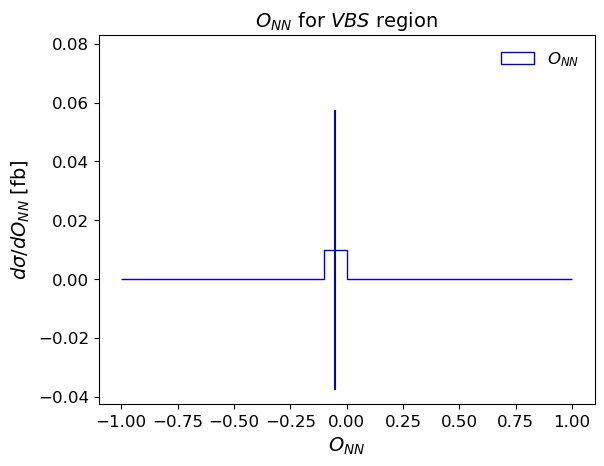

O_NN Fractional Uncertainty: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         4.87887469 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


UnboundLocalError: cannot access local variable 'www_history' where it is not associated with a value

In [ ]:
def __main__():
    vbs_data = DataLoader("VBS_data_cwtil_2.feather", ['Electron.Eta', 'Electron.Phi', 'Muon.Eta', 'Muon.Phi'])
    model_filename = "vbs_l_eta_phi.keras"

    param_grid = {
            'learning_rate': [0.001, 0.005, 0.01],
            'neurons': [16, 32, 64],
            'layers': [2, 4],
            'reg_strength': [0, 0.0001, 0.001],
            'patience': [2],
            'batch_size': [128],
            'dropout': [0, 0.2],
        }

    if os.path.exists(model_filename):
        print(f"Loading existing model for {model_filename}")
    else:
        print("No existing model found, training new model")
        vbs_model = MLModel()
        vbs_model.grid_search(vbs_data.x_data, vbs_data.y_data, param_grid, model_filename)
    
    vbs_model, vbs_history = MLModel.load_ML_model(model_filename)

    vbs_results = vbs_model.predict(vbs_data.x_data)
    Plotter.plot_ML_observable(vbs_results, vbs_data.weight_data, "VBS", 2)
    Plotter.plot_loss(vbs_history)
    Plotter.plot_accuracy(vbs_history)

if __name__ == '__main__':
    __main__()